# BERT Example

In this notebook, we will load and use a BERT model using the pre-existing Language Models provided by Hugging Face https://huggingface.co/.

The full list of available language models is found at https://huggingface.co/transformers/pretrained_models.html.

To use the existing language models install the `transformers` package by running: 

`!pip install transformers`


## Import Required Modules

In [3]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np

### Define the model that is going to be used

In [4]:
model_name = 'bert-base-uncased'

## Prepare the Tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [6]:
def prepare_tokens(text, start_token="[CLS]", end_token="[SEP]"):
    """Prepares the sentence to be appropriately tokenized for BERT
    
    Args:
        sentence (str): The sentence to be tokenized.
    
    Returns:
        A list of strings representing the sentence tokenization.
        
    """
    marked_text = start_token + text + end_token
    indexed_tokens = tokenizer.encode(text, add_special_tokens=True)
    return (tokenizer.tokenize(marked_text), indexed_tokens)

Setup the text that is going to be used throughout the example

In [7]:
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

In [8]:
tokenized_text, indexed_tokens = prepare_tokens(text)

In [9]:
# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### Prepare Inputs for Selected Model

In [11]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [0] * len(tokenized_text)

In [12]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [13]:
tokens_tensor

tensor([[  101,  2044, 11065,  2769,  2013,  1996,  2924, 11632,  1010,  1996,
          2924, 27307,  2001,  2464,  5645,  2006,  1996,  5900,  2314,  2924,
          1012,   102]])

In [14]:
segments_tensors

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Load the Pre-Trained Model
This step might take a while... The first time you will use the selected model, it will download it from the repository.

In [15]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained(model_name, output_hidden_states=True)

In [16]:
# Put the model in "evaluation" mode, meaning feed-forward operation
# This will also deactivate the dropout component of the model
model = model.eval()

In [17]:
with torch.no_grad():
    encoded_layers = model(tokens_tensor, token_type_ids=segments_tensors)

In [18]:
hidden_states = encoded_layers[2]
print ("Number of layers:", len(hidden_states))
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


In [20]:
import matplotlib.pyplot as plt

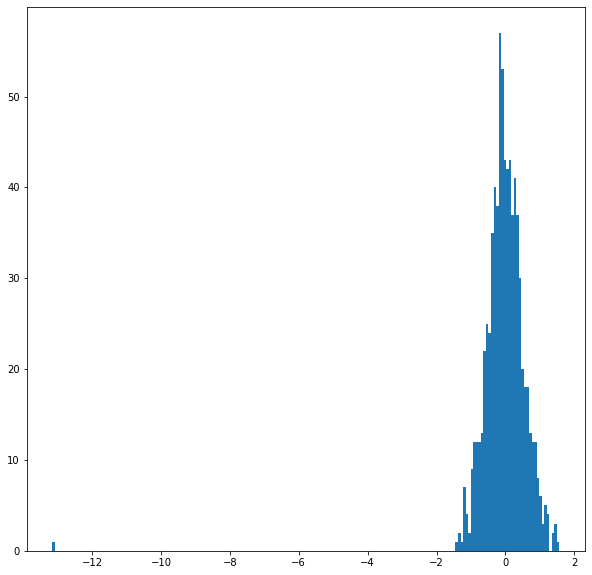

In [21]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

### Redistribute Embeddings Tensor
Redistribute tensor such that the first dimension correspond to the token, the second dimension to the BERT layer, and the third dimension correspond to the token embedding (features).

In [22]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [23]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([13, 22, 768])

In [24]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([22, 13, 768])

### Word Vectors: Concatenation

In [25]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


### Word Vectors: SUM

In [26]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


### Sentence Vectors

In [27]:
torch.mean(torch.stack(hidden_states[10:], dim=0), dim=0)[0].size()

torch.Size([22, 768])

In [28]:
# `encoded_layers` has shape [12 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[11][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

## Confirming Contextually Dependent Vectors

In [30]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [31]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


In [34]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])
print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69
